In [64]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

# process load time data
systems = ['Baseline', 'DLCache']
worker_num = [8]
compute_time = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
batch_size = [64, 128, 256, 512]
repeats = 3
data = []

for s in systems:
    for w in worker_num:
        for r in range(repeats):
            for b in batch_size:
                for c in compute_time:
                    try:
                        dir = "{}/worker={}/run{}/{}/{}".format(s, w, r, c, b)
                        load_time = np.sum(np.load('{}/load_time.npy'.format(dir)))
                        if os.path.exists('{}/train_cache_usage.npy'.format(dir)):
                            avg_cache_usage = np.load('{}/train_cache_usage.npy'.format(dir))
                            avg_cache_usage = np.mean(avg_cache_usage, dtype=int) / 2
                            cache_hits = 0
                            for ch in glob.glob("{}/cache_hits*".format(dir)):
                                cache_hits += np.load(ch)
                            cache_hit_rate = cache_hits / (b * 100)
                            cache_hit_rate /= 2
                            opt_worker_num = np.load('{}/worker_num_hist.npy'.format(dir))[-1]
                        else:
                            avg_cache_usage = 0
                            cache_hit_rate = 0
                            opt_worker_num = 8
                            
                        memory_usage = np.mean(np.load('{}/memory_usage.npy'.format(dir))[20:])
                        data.append([s, c, b, load_time, avg_cache_usage, cache_hit_rate, w, memory_usage, opt_worker_num])
                    except Exception as ex:
                        pass

data = pd.DataFrame(data, columns=['Method', 'compute_time', 'batch_size', 'load_time', 'avg_cache_usage', 'cache_hit_rate', 'num_workers', 'memory', 'opt_num_worker'])
data.sort_values(by='compute_time', inplace=True)
data.to_csv('data.csv', index=False)

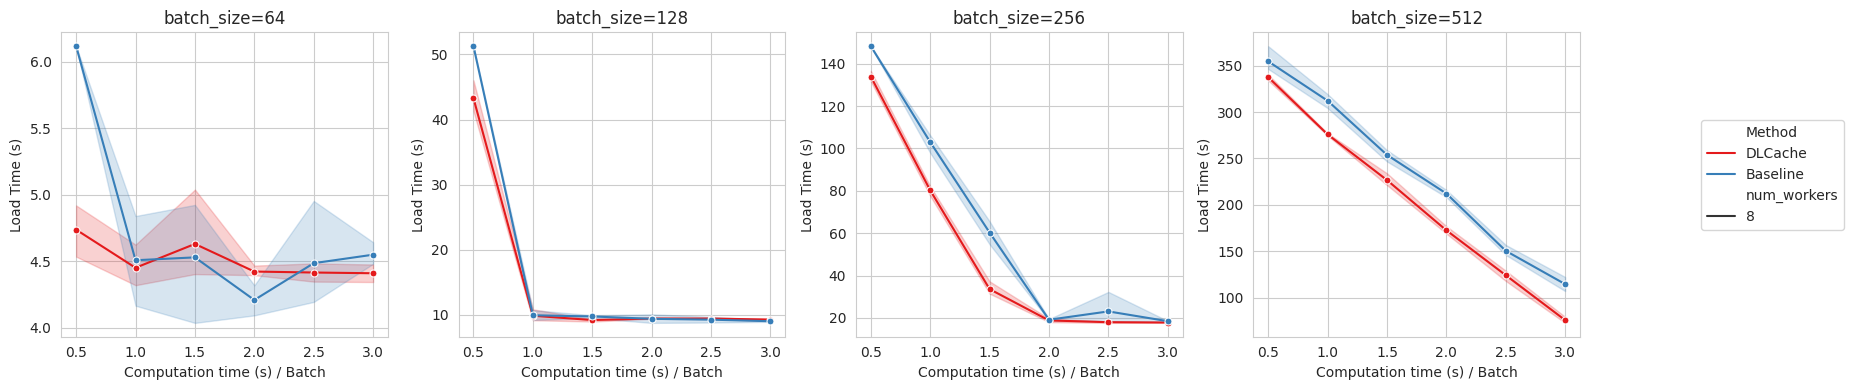

In [65]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

markers = ['.', '*']
for j, b in enumerate(batch_size):
    slice = data[data['batch_size']==b].sort_values(by='compute_time')
    compute_time_ticks = []
    for ct in slice['compute_time']:
        compute_time_ticks.append(compute_time.index(ct))
    slice['compute_time'] = compute_time_ticks
    # ax = sns.boxplot(ax=axes[j], data=slice, x='compute_time', y='load_time', hue='Method', hue_order=['DLCache', 'Baseline'])
    ax = sns.lineplot(ax=axes[j], data=slice, x='compute_time', y='load_time', hue='Method', hue_order=['DLCache', 'Baseline'], 
                        marker='.', markersize=10, style='num_workers', palette = "Set1")
    ax.get_legend().remove()
    ax.set_xticks(np.arange(len(compute_time)))
    ax.set_xticklabels(compute_time)
    ax.set_xlabel('Computation time (s) / Batch')
    ax.set_ylabel('Load Time (s)')
    ax.set_title('batch_size={}'.format(b))

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', ncol=1, bbox_to_anchor=(1.16, 0.55))
plt.tight_layout()
plt.savefig("./images/load_time.png", dpi=300)
plt.show()

In [66]:
# for b in batch_size:
#     slices = []
#     for s in systems:
#         slice = data[(data['Method']==s) & (data['batch_size']==b)].sort_values(by='compute_time')
#         slice = slice.groupby(by='compute_time').median().reset_index()
#         slices.append(slice['load_time'].values)
    
#     imp = 100 * (slices[0] - slices[1])/slices[0]
#     imp = pd.DataFrame([compute_time, imp]).T
#     imp.columns = ['compute_time', 'improvement(%)']
#     compute_time_ticks = []
#     for ct in slice['compute_time']:
#         compute_time_ticks.append(compute_time.index(ct))
#     imp['compute_time'] = compute_time_ticks
#     ax = sns.lineplot(x='compute_time', y='improvement(%)', data=imp, label='batch_size={}'.format(b), marker= '.', markersize=10)
#     # sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    
# plt.xticks(np.arange(len(compute_time)), compute_time, fontsize=12)
# plt.yticks(fontsize=12)
# plt.xlabel('Computation time (s) / Batch', fontsize = 15)
# plt.ylabel('Improvement (%)', fontsize = 15)
# plt.show()

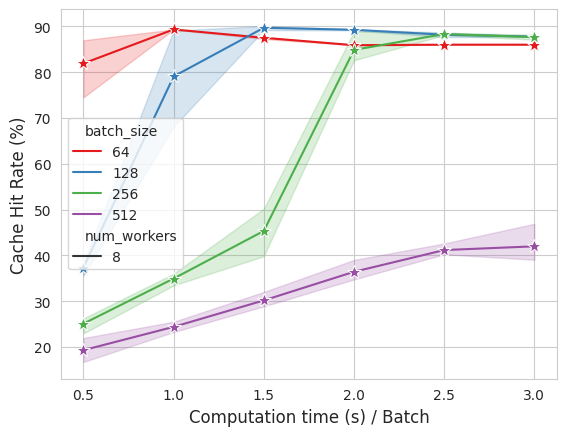

In [67]:
slice = data[(data['Method']=='DLCache')].sort_values(by='compute_time')
compute_time_ticks = []
for ct in slice['compute_time']:
    compute_time_ticks.append(compute_time.index(ct))
slice['compute_time'] = compute_time_ticks
slice['cache_hit_rate'] *= 100.0
ax = sns.lineplot(x='compute_time', y='cache_hit_rate', data=slice, hue='batch_size', 
                    style='num_workers', marker= '*', markersize=10, palette = "Set1")
ax.set_xticks(np.arange(len(compute_time)))
ax.set_xticklabels(compute_time)
ax.set_xlabel('Computation time (s) / Batch', fontsize=12)
ax.set_ylabel('Cache Hit Rate (%)', fontsize=12)
plt.savefig("./images/cache_hit.png", dpi=300)
plt.show()

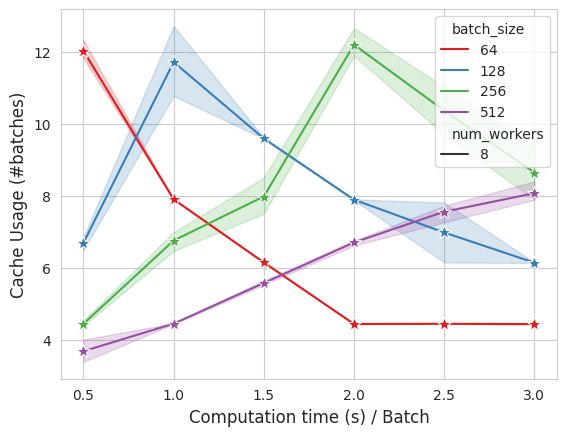

In [68]:
slice = data[(data['Method']=='DLCache')].sort_values(by='compute_time')
compute_time_ticks = []
for ct in slice['compute_time']:
    compute_time_ticks.append(compute_time.index(ct))
slice['compute_time'] = compute_time_ticks
slice['cache_usage'] = slice['avg_cache_usage'] / slice['batch_size']
ax = sns.lineplot(x='compute_time', y='cache_usage', data=slice, hue='batch_size', 
                    style='num_workers', marker= '*', markersize=10, palette = "Set1")
ax.set_xticks(np.arange(len(compute_time)))
ax.set_xticklabels(compute_time)
ax.set_xlabel('Computation time (s) / Batch', fontsize=12)
ax.set_ylabel('Cache Usage (#batches)', fontsize=12)
plt.savefig("./images/cache_usage.png", dpi=300)
plt.show()

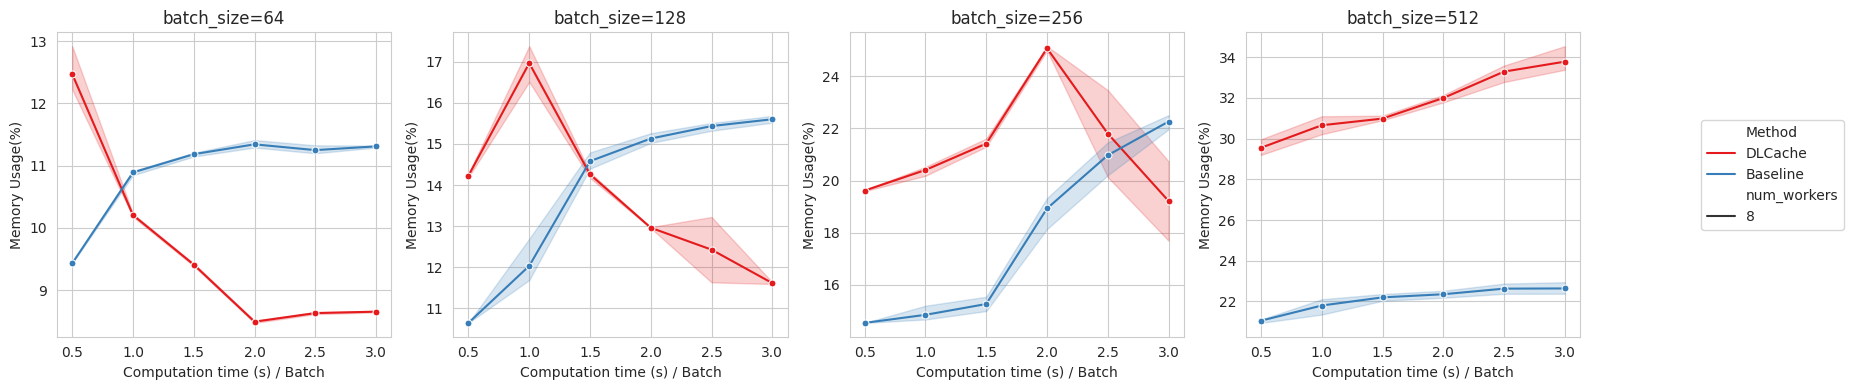

In [69]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

markers = ['.', '*']
for j, b in enumerate(batch_size):
    slice = data[data['batch_size']==b].sort_values(by='compute_time')
    compute_time_ticks = []
    for ct in slice['compute_time']:
        compute_time_ticks.append(compute_time.index(ct))
    slice['compute_time'] = compute_time_ticks
    # ax = sns.boxplot(ax=axes[j], data=slice, x='compute_time', y='load_time', hue='Method', hue_order=['DLCache', 'Baseline'])
    ax = sns.lineplot(ax=axes[j], data=slice, x='compute_time', y='memory', hue='Method', hue_order=['DLCache', 'Baseline'], 
                        marker='.', markersize=10, style='num_workers', palette = "Set1")
    ax.get_legend().remove()
    ax.set_xticks(np.arange(len(compute_time)))
    ax.set_xticklabels(compute_time)
    ax.set_xlabel('Computation time (s) / Batch')
    ax.set_ylabel('Memory Usage(%)')
    ax.set_title('batch_size={}'.format(b))

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', ncol=1, bbox_to_anchor=(1.16, 0.55))
plt.tight_layout()
plt.show()

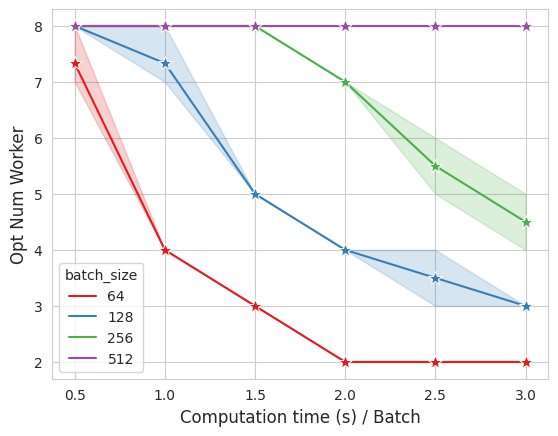

In [70]:
slice = data[(data['Method']=='DLCache')].sort_values(by='compute_time')
compute_time_ticks = []
for ct in slice['compute_time']:
    compute_time_ticks.append(compute_time.index(ct))
slice['compute_time'] = compute_time_ticks
ax = sns.lineplot(x='compute_time', y='opt_num_worker', data=slice, hue='batch_size', marker= '*', markersize=10, palette = "Set1")
ax.set_xticks(np.arange(len(compute_time)))
ax.set_xticklabels(compute_time)
ax.set_xlabel('Computation time (s) / Batch', fontsize=12)
ax.set_ylabel('Opt Num Worker', fontsize=12)
plt.show()